# Lotka-Volterra Work-Precision Diagrams

https://benchmarks.juliadiffeq.org/html/NonStiffODE/LotkaVolterra_wpd.html

The purpose of this problem is to test the performance on easy problems. Since it's periodic, the error is naturally low, and so most of the difference will come down to startup times and, when measuring the interpolations, the algorithm choices.

In [1]:
using OrdinaryDiffEq, ParameterizedFunctions, ODE, ODEInterfaceDiffEq, LSODA,
      Sundials, DiffEqDevTools

In [2]:
using Plots; gr()

Plots.GRBackend()

In [3]:
f = @ode_def LotkaVolterra begin
  dx = a*x - b*x*y
  dy = -c*y + d*x*y
end a b c d

(::LotkaVolterra{var"#7#11",var"#8#12",var"#9#13",Nothing,Nothing,var"#10#14",Expr,Expr}) (generic function with 2 methods)

In [4]:
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(f,[1.0;1.0],(0.0,10.0),p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

In [5]:
abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10);
sol = solve(prob,Vern7(),abstol=1/10^14,reltol=1/10^14)
test_sol = TestSolution(sol)

retcode: Success
Interpolation: specialized 7th order lazy interpolation
t: nothing
u: nothing

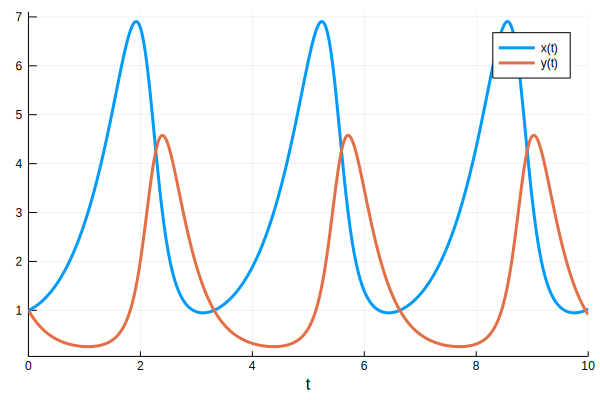

In [6]:
plot(sol)

# Low Order

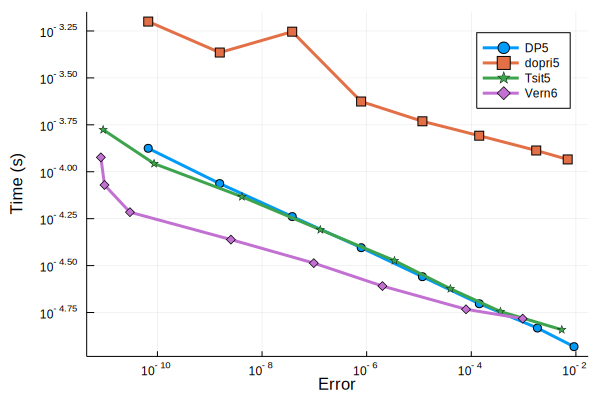

In [7]:
setups = [Dict(:alg=>DP5())
          #Dict(:alg=>ode45()) # fail
          Dict(:alg=>dopri5())
          Dict(:alg=>Tsit5())
          Dict(:alg=>Vern6())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,maxiters=10000,numruns=100)
plot(wp)

# Interpolation Error

Since the problem is periodic, the real measure of error is the error throughout the solution.

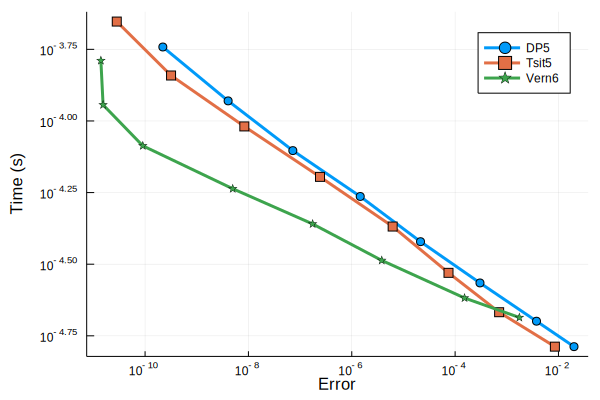

In [8]:
setups = [Dict(:alg=>DP5())
          #Dict(:alg=>ode45())
          Dict(:alg=>Tsit5())
          Dict(:alg=>Vern6())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,maxiters=10000,error_estimate=:L2,dense_errors=true,numruns=100)
plot(wp)

Here we see the power of algorithm specific interpolations. The ODE.jl algorithm is only able to reach $10^{−7}$ error even at a tolerance of $10^{−13}$, while the DifferentialEquations.jl algorithms are below $10^{−10}$.

# Higher Order

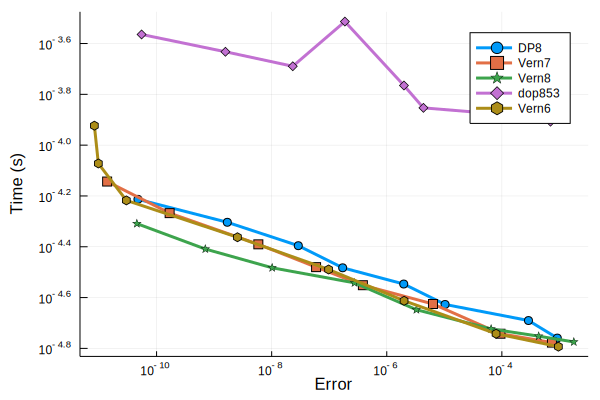

In [9]:
setups = [Dict(:alg=>DP8())
          #Dict(:alg=>ode78()) # fails
          Dict(:alg=>Vern7())
          Dict(:alg=>Vern8())
          Dict(:alg=>dop853())
          Dict(:alg=>Vern6())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,maxiters=1000,numruns=100)
plot(wp)

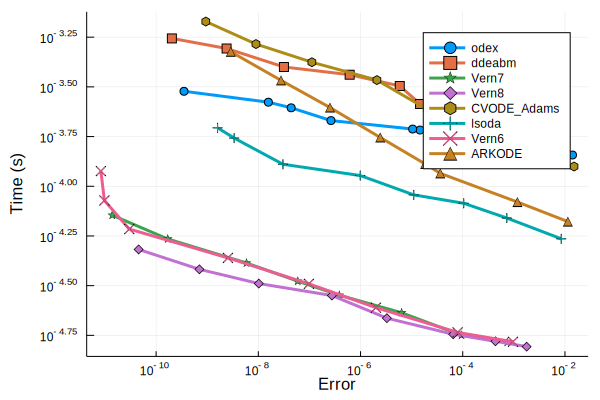

In [10]:
setups = [Dict(:alg=>odex())
          Dict(:alg=>ddeabm())
          Dict(:alg=>Vern7())
          Dict(:alg=>Vern8())
          Dict(:alg=>CVODE_Adams())
          Dict(:alg=>lsoda())
          Dict(:alg=>Vern6())
          Dict(:alg=>ARKODE(Sundials.Explicit(),order=6))
          ]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,maxiters=1000,numruns=100)
plot(wp)

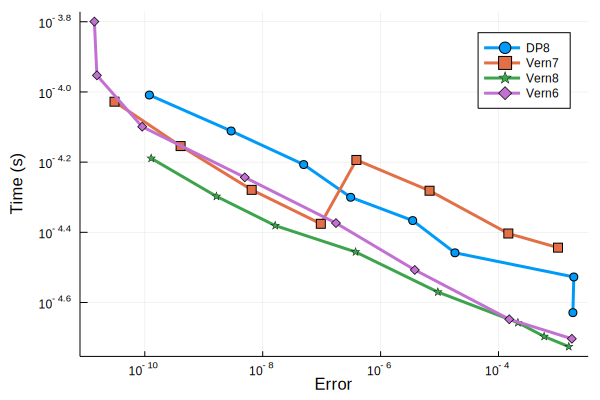

In [11]:
setups = [Dict(:alg=>DP8())
          #Dict(:alg=>ode78())
          Dict(:alg=>Vern7())
          Dict(:alg=>Vern8())
          Dict(:alg=>Vern6())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,dense=true,maxiters=1000,error_estimate=:L2,numruns=100)
plot(wp)

Again, the ODE.jl algorithms suffer when measuring the interpolations due to relying on an order 3 Hermite polynomial instead of an algorithm-specific order matching interpolation which uses the timesteps.

# Comparison with non-RK methods

Now let's test Tsit5 and Vern9 against parallel extrapolation methods and an Adams-Bashforth-Moulton:

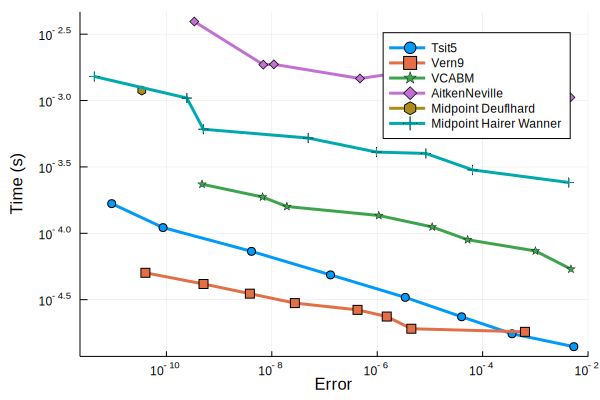

In [12]:
setups = [Dict(:alg=>Tsit5())
          Dict(:alg=>Vern9())
          Dict(:alg=>VCABM())
          Dict(:alg=>AitkenNeville(min_order=1, max_order=9, init_order=4, threading=true))
          Dict(:alg=>ExtrapolationMidpointDeuflhard(min_order=1, max_order=9, init_order=4, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=4, threading=true))]
solnames = ["Tsit5","Vern9","VCABM","AitkenNeville","Midpoint Deuflhard","Midpoint Hairer Wanner"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                      save_everystep=false,verbose=false,numruns=100)
plot(wp)

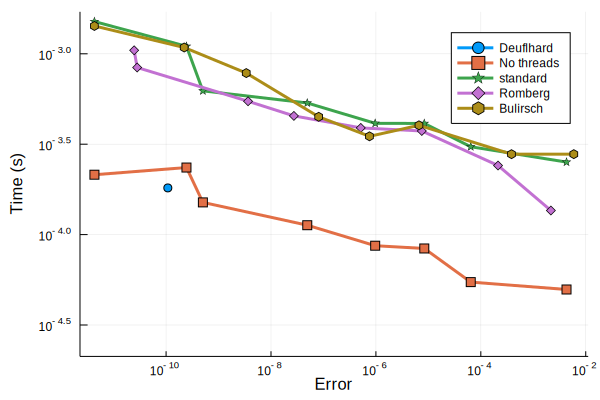

In [13]:
setups = [Dict(:alg=>ExtrapolationMidpointDeuflhard(min_order=1, max_order=9, init_order=9, threading=false))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=4, threading=false))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=4, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=4, sequence = :romberg, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=4, sequence = :bulirsch, threading=true))]
solnames = ["Deuflhard","No threads","standard","Romberg","Bulirsch"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                      save_everystep=false,verbose=false,numruns=100)
plot(wp)

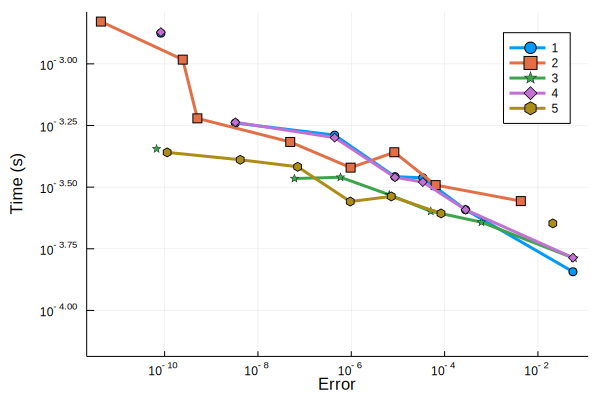

In [14]:
setups = [Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=10, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=11, init_order=4, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=5, max_order=11, init_order=10, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=2, max_order=15, init_order=10, threading=true))
          Dict(:alg=>ExtrapolationMidpointHairerWanner(min_order=5, max_order=7, init_order=6, threading=true))]
solnames = ["1","2","3","4","5"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                      save_everystep=false,verbose=false,numruns=100)
plot(wp)

# Conclusion

The OrdinaryDiffEq.jl are quicker and still solve to a much higher accuracy, especially when the interpolations are involved. ODE.jl errors a lot.